# Filter performance comparison

NOTE: This notebook is supporting for python 2 only.

## Install pilgram

In [0]:
!pip install pillow pilgram==1.0.3

     |████████████████████████████████| 768kB 2.8MB/s 
  Created wheel for pilgram: filename=pilgram-1.0.3-cp27-none-any.whl size=792502 sha256=d7d6a766d2594a8329a5f89f9750eace86b14f48605c9096fe3ffde67d47012a
  Stored in directory: /root/.cache/pip/wheels/5c/d9/c4/984f93fd483c23cf3ea5b2da12584b3b3beb8ea8a8500a0977
Successfully built pilgram


## Insetall instagram-filters

In [0]:
!sudo apt-get install -y imagemagick

%cd /content
!git clone https://github.com/acoomans/instagram-filters.git
!sed -i 's/^import Image$/from PIL import Image/' instagram-filters/instagram_filters/filter.py # Fix for using pillow
!pip install --no-deps -e instagram-filters

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

## Setup

In [0]:
!pip install seaborn

In [0]:
%cd /content
!wget "https://github.com/akiomik/pilgram/blob/master/notebooks/mtjimba.jpg?raw=true" -O mtjimba.jpg
!cp mtjimba.jpg if_Kelvin_mtjimba.jpg
!cp mtjimba.jpg if_Nashville_mtjimba.jpg
!cp mtjimba.jpg if_Toaster_mtjimba.jpg

/content
--2019-11-14 10:34:08--  https://github.com/akiomik/pilgram/blob/master/notebooks/mtjimba.jpg?raw=true
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/akiomik/pilgram/raw/master/notebooks/mtjimba.jpg [following]
--2019-11-14 10:34:08--  https://github.com/akiomik/pilgram/raw/master/notebooks/mtjimba.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/akiomik/pilgram/master/notebooks/mtjimba.jpg [following]
--2019-11-14 10:34:08--  https://raw.githubusercontent.com/akiomik/pilgram/master/notebooks/mtjimba.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP requ

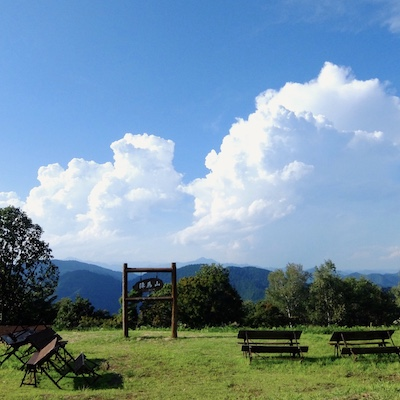

In [0]:
from time import time
import shutil

from IPython import display
import matplotlib.pyplot as plt
from PIL import Image


N_LOOP = 1000  # @param

elapsed_time = {
  'pilgram': {},
  'instagram_filters': {}
}

original_image_name = '/content/mtjimba.jpg'
pilgram_image_names = ['/content/pilgram_kelvin_mtjimba.jpg', '/content/pilgram_nashville_mtjimba.jpg', '/content/pilgram_toaster_mtjimba.jpg']
if_image_names = ['/content/if_Kelvin_mtjimba.jpg', '/content/if_Nashville_mtjimba.jpg', '/content/if_Toaster_mtjimba.jpg']

display.display_jpeg(display.Image(original_image_name))

## Performance measurement (pilgram)

In [0]:
%%time
%cd /content

import pilgram


pilgram_filter_names = ['kelvin', 'nashville', 'toaster']
for filter_name, image_name in zip(pilgram_filter_names, pilgram_image_names):
  time1 = time()
  for i in range(N_LOOP):
    shutil.copy(original_image_name, image_name)
    filter = getattr(pilgram, filter_name)
    im = Image.open(image_name)
    im2 = filter(im)
    im2.save(image_name)
  time2 = time()
  elapsed_time['pilgram'][filter_name] = time2 - time1

/content
CPU times: user 1min 4s, sys: 1.95 s, total: 1min 6s
Wall time: 1min 7s


## Performance measurement (instagram-filters)

In [0]:
%%time
%cd /content/instagram-filters

from instagram_filters import filters


if_filter_names = ['Kelvin', 'Nashville', 'Toaster']
for filter_name, image_name in zip(if_filter_names, if_image_names):
  time1 = time()
  for i in range(N_LOOP):
    shutil.copy(original_image_name, image_name)
    filter = getattr(filters, filter_name)
    f = filter(image_name)
    f.apply()
  time2 = time()
  elapsed_time['instagram_filters'][filter_name] = time2 - time1

/content/instagram-filters
CPU times: user 10.5 s, sys: 30.4 s, total: 41 s
Wall time: 11min 15s


## Comparison

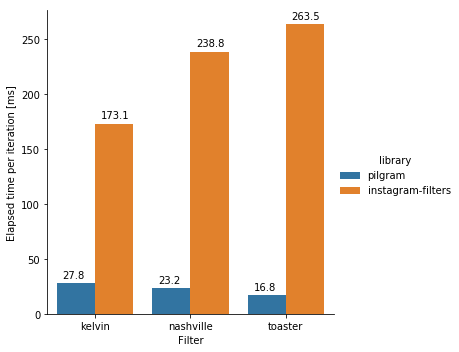

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns


df = pd.DataFrame(data={
  'library': ['pilgram'] * 3 + ['instagram-filters'] * 3,
  'filter': pilgram_filter_names + pilgram_filter_names,
  'elapsed_time': np.array(elapsed_time['pilgram'].values() + elapsed_time['instagram_filters'].values()) / N_LOOP * 1000,
})

g = sns.catplot(x = 'filter', y = 'elapsed_time', hue='library', data = df, kind = 'bar')
g.set_axis_labels("Filter", "Elapsed time per iteration [ms]")
g.set_titles("Performance comparison")
for p in g.ax.patches:
  x = p.get_x() + .06
  y = p.get_height() + 5
  g.ax.annotate('{:.1f}'.format(p.get_height()), (x, y))
plt.show()

<Figure size 432x288 with 0 Axes>

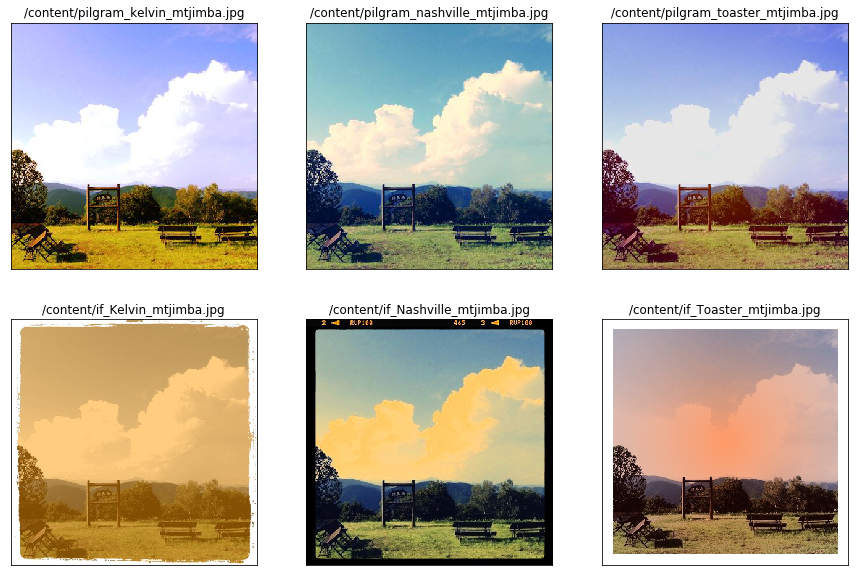

In [0]:
plt.subplots_adjust(wspace=0.2, hspace=-2)

image_names = pilgram_image_names + if_image_names
rows = 2
columns = len(pilgram_image_names)
fig = plt.figure(figsize=(columns * 5, rows * 5))
for i, image_name in enumerate(image_names):
  im = Image.open(image_name)
  ax = fig.add_subplot(rows, columns, i + 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(image_name)
  ax.imshow(im)
plt.show()